In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pyplot as plt

/Users/yclin/miniforge3/envs/torch_rl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [96]:
def stat(x):
    m = x.mean(0, keepdim=True)
    s = (x - m).square().mean().sqrt()
    print(s)

b = torch.randn(10)
w = torch.randn(10, 100) / np.sqrt(100)

s = torch.randn(100) * 3
t = torch.randn(10, 100) / np.sqrt(10)
r = 0.125

x0 = torch.randn(10000, 10) @ t
y0 = F.linear(x0, w, b) + r * torch.randn(10000, 10)

x1 = torch.randn(1000, 10) @ t + s
y1 = F.linear(x1, w, b) + r * torch.randn(1000, 10)

var = 0.5

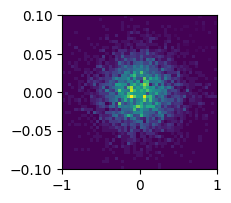

In [100]:
_, ax = plt.subplots(figsize=(2,2))
u = (x0.T @ x0 / len(x0)).flatten().numpy()
v = (w.T @ w).flatten().numpy()
ax.hist2d(u, v, bins=50, range=((-1, 1), (-.1, .1)))
None

In [139]:
train_set = torch.utils.data.TensorDataset(x0, y0)
test_set = torch.utils.data.TensorDataset(x1, y1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

def run(model, loss_fn, optim, num_samples, num_frames):

    _, axes = plt.subplots(ncols=num_frames, figsize=(2*num_frames, 2))
    if num_frames == 1:
        axes = [axes]
    progress = tqdm.trange(100*num_frames)
    for epoch in progress:

        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optim.zero_grad()
            outputs = model(inputs)
            losses = loss_fn(outputs, targets)
            losses.backward()
            optim.step()
            train_loss += losses.item() / len(train_loader)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                losses = loss_fn(outputs, targets)
                test_loss += losses.item() / len(test_loader)

        progress.set_postfix({
            "train_loss": f"{train_loss:.4f}",
            "test_loss": f"{test_loss:.4f}",
        })

        if (epoch+1)%100 == 0:
            i = epoch//100
            w = model[-1].weight.detach()
            u = (x0.T @ x0 / len(x0)).flatten().numpy()
            v = (w.T @ w).flatten().numpy()
            axes[i].hist2d(u, v, bins=50, range=((-1, 1), (-.01, .01)))
None

100%|██████████| 100/100 [00:04<00:00, 23.53it/s, train_loss=0.0554, test_loss=8.7312]


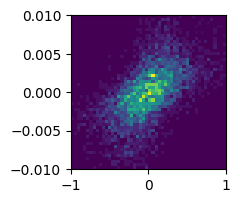

In [140]:
class Dropout(nn.Module):

    def __init__(self, var):
        super().__init__()
        self.std = np.sqrt(var)

    def forward(self, x):
        if self.training:
            d = torch.randn_like(x) * self.std + 1
            x = x * d
        return x

model = nn.Sequential(
    Dropout(var),
    nn.Linear(100, 10),
)
loss_fn = nn.MSELoss(reduction="mean")
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
run(model, loss_fn, optim, num_samples=1, num_frames=1)

0.0179 8.7641


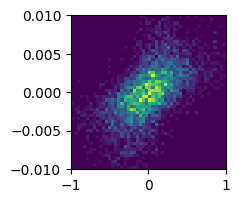

In [143]:
def cov(a, b):
    n = len(a)
    return a.T @ b / n - a.mean(0)[:, None] * b.mean(0)[None, :]

cov_xx = cov(x0, x0)
cov_yx = cov(y0, x0)
wl = cov_yx @ torch.inverse(cov_xx + var * x0.square().mean(0).diag_embed())
bl = y0.mean(0) - wl @ x0.mean(0)

train_loss = 0
for inputs, targets in train_loader:
    outputs = F.linear(inputs, wl, bl)
    losses = loss_fn(outputs, targets)
    train_loss += losses.item() / len(train_loader)

test_loss = 0
for inputs, targets in test_loader:
    outputs = F.linear(inputs, wl, bl)
    losses = loss_fn(outputs, targets)
    test_loss += losses.item() / len(test_loader)

print("%.4f %.4f" % (train_loss, test_loss))

_, ax = plt.subplots(figsize=(2,2))
u = (x0.T @ x0 / len(x0)).flatten().numpy()
v = (wl.T @ wl).flatten().numpy()
ax.hist2d(u, v, bins=50, range=((-1, 1), (-.01, .01)))
None

In [160]:
for i in 5:
    print(i)

TypeError: 'int' object is not iterable